# Introduction

In almost every aspect of life, the power of unconscious and subconscious biases exists to aid in shaping everyday decisions. Often times, people tend to remember the negative or unfavorable portrayal of different groups whether they be ethnic, gendered, or political. Studies have proved that minorities have received unfavorable and disadvantaged outcomes when it comes to criminal justice including racial profiling of drivers. Humans rely on the police to protect the public from harm while promoting fairness, equality and justice in communities. In recent years however, racial profiling has led the public to live in fear as it defamed many minority communities into becoming “suspects” based of off their physical appearances, their backgrounds, cultures and religions. Due to this, many cities including San Diego have seen an increase in tensions between the city’s police forces and its residents.

As one of the safest cities in California, San Diego is the eighth largest city in the United States and one of the most diverse places to live. Due to the diversity of this population and increased tension in the population, this project aims to calculate whether the racial disparity in police traffic stop data in the city of San Diego is significant or nonexistent. In order to get a better idea, data from between January 1, 2014 – December 31, 2019 will be used. This data consists of why the driver was stopped, whether there was a citation or warning issued, whether a field interview was conducted, whether a search was initiated, whether property was seized, whether contraband was discovered and whether an arrest occurred along with the area code and time/length of stop. 

Previously, SDSU conducted a similar analysis that consisted of “259,569 traffic stops initiated by San Diego Police Department (SDPD) officers between January 1, 2014 and December 31, 2015” (Chanin, ii). They focused on the reasoning for initiating a traffic stop, whether a citation was issued, whether a field interview was conducted, whether a search was initiated, whether contraband was found and whether an arrest was made. Unsurprisingly, this study found disparities between White and Black drivers in 2014 and found that while Black and Hispanic drivers had higher rates of being searched after a traffic stop was initiated, they had lower rates than White drivers of being found with contraband (Chanin, ii). Some inherent shortcomings during the SDSU analysis were the shortage of officers in the San Diego area, the lack of diversity among the officers compared to the actual city population and the disproportionate quantity of officers patrolling certain areas with respect to the crime rates. 

While the data collection from 2018 onwards has years of experience of the officer, no data collection has the race or ethnicity of the officer themselves. The SDSU data also lacks information about the specific geo-location of the stops and searches, what was seized, the vehicle information or demeanors of the passengers/drivers of the cars. They also omitted traffic stops that “occurred as a result of a suspect description, code enforcement effort, or other type of call for service” (Chanin, iii). Thus, they limited their data sample to consist of stops that discretionary decisions like moving violations or things like a broken tail light. Another technique used for the SDSU analysis was an approach on the ‘Veil of Darkness’. This technique is based off of the assumption that bias over the race or ethnicity of a driver will be more visible in the daylight then stops conducted when it is dark outside as the night makes it harder to detect physical appearance. The SDSU study’s approach was to use the ‘inner-twilight period’ which took into consideration the seasonal time changes between summer and winter. Similar to the SDSU study, a previous study on SDPD traffic stop data was done in 2000 and 2001. This previous study caused the validity of the vehicle stop data to be questioned as the vehicle stop forms were not being filled out regularly. Another inconsistency is that 19% of the traffic stop records submitted possessed as least one missing data piece (Chanin, 15). 



In [1]:
import pandas as pd
import os
import json
import glob
import numpy as np
import doctest
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoSeries
from shapely.geometry import Polygon
import sys
import seaborn as sns

In [2]:
from postclean import *

ModuleNotFoundError: No module named 'postclean'

# Getting the Data

In this sections, we call on the process file which gets the data and also cleans it. Basically, a configuration file with the years of the data we want, as well as the columns we are looking for are taken in along with the output and in return, we get a compilation of csv files of the data. In this we also create pre2018 and post2018 datasets as the post2018 dataset has less granuality and in a very different format than the pre2018.

In [12]:

sys.path.append('../')
sys.path.append('src')
from etl import *
from process import *

In [13]:
cfg = json.load(open('config/test-params.json'))

In [16]:
get_data(**cfg)
owd = os.getcwd()
os.chdir("data/raw")

In [17]:
df1 = make_df(**cfg)

FileNotFoundError: [Errno 2] File b'../data/raw/2014.csv' does not exist: b'../data/raw/2014.csv'

In [6]:
owd = os.getcwd()
os.chdir("data/raw")

In [11]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
all_filenames = np.sort(all_filenames)
newnames = all_filenames[:4]
pr2018 = pd.concat([pd.read_csv(f) for f in newnames ]).reset_index(drop = True)
#pr2018['year'] = pr2018['date_stop'].astype(str).str[:4]
#pr2018['year'] = pr2018['year'].astype(int)
pr2018 = pr2018[wanted_columns_pre]

/Users/hudaahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


KeyError: "None of [Index(['stop_id', 'stop_cause', 'date_stop', 'time_stop', 'subject_race',\n       'subject_sex', 'subject_age', 'service_area', 'sd_resident',\n       'property_seized', 'searched', 'arrested', 'obtained_consent',\n       'contraband_found', 'year'],\n      dtype='object')] are in the [columns]"

In [8]:
consent = pd.read_csv(all_filenames[5])[['stop_id', 'consented']]
contra = pd.read_csv(all_filenames[6])[['stop_id', 'contraband']]
seiz = pd.read_csv(all_filenames[7])[['stop_id', 'type_of_property_seized']]
race = pd.read_csv(all_filenames[8])[['stop_id', 'race']]
search = pd.read_csv(all_filenames[9])[['stop_id', 'basis_for_search']]
whystop = pd.read_csv(all_filenames[10])[['stop_id', 'reason_for_stop']]
stopresult = pd.read_csv(all_filenames[11])[['stop_id', 'result']]


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
pt2018 = pd.read_csv(all_filenames[4])
pt2018 = pt2018.merge(consent, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(contra, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(seiz, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(race, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(search, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(whystop, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018 = pt2018.merge(stopresult, on='stop_id')
pt2018 = pt2018.drop_duplicates(subset = 'stop_id')
pt2018['year'] = pt2018['date_stop'].astype(str).str[:4]
pt2018['year'] = pt2018['year'].astype(int)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning the Data

In this section, we call on the process.py file that has all of the functions needed to clean the data. There will be subsets of precision, accuracy and missingness that we deal with. 

pre2018:
In terms of race code, since the post2018 dataset had less granuality for the race column, I decided to convert the pre2018 dataset to match it. The precise races were accurately classified in accordance to the census guidelines under race. For example: 'Chinese' and 'Korean' were classified as 'Asian'. I created a binary_clean function that cleans are the columns with Yes's and No's and Nans into 0's and 1's. If there was a missing value, I assumed that there was no search or property seized. For the subject_sex, I created a function that sets the missing values to 0, males to 1, females to 2, and other to 3. In terms of the subject_age, I decided to keep all of the np.nan values so further on in my analysis, I could have the opportunity to decide whether I want to drop the null age values or do some sort of imputation.



post2018:
For the post2018 dataset, I used the same methods as pre2018 to clean up the property_seized and searched columns becaause if they had float values, that meant that there was no search conducted or property seized so I set it to 0 and if there was a string, meaning those occured, I set it to 1. For sd_resident, I just mapped whether they were in San Diego or not. Beats was the most complicated in tryint to figure out the most efficient way to turn beats into service areas but the way I decided to use was to read the police beats csv and take the beats and service areas columns and create a dictionary which I then mapped to the dataset.



In terms of the column choice, I decided to stick with searched, property_seized and stop_cause because I believed that in order to be arrested, one needs to be searched so that made it redundant information.

In [10]:
pre2018 = pre18(pr2018)
pre2018 = clean_time(pre2018)
post2018 = post18(pt2018)
post2018 = clean_time(post2018)

In [11]:
allyears = pd.concat([pre2018, post2018], axis = 0).reset_index(drop=True)

In [12]:
getdir = os.getcwd()
os.chdir(owd)
os.getcwd()

'/datasets/home/home-02/64/264/h8ahmed/DSC180A-DS-Methodology/assignments/FinalProject'

In [13]:
if not os.path.exists("data/out"):
    os.mkdir("data/out")
#tables.to_csv("%s/%s.csv"%(outpath, year))
allyears.to_csv("data/out/combined.csv")
pre2018.to_csv("data/out/pre2018.csv")
post2018.to_csv("data/out/post2018.csv")

# EDA, Descriptive Statistics and Traffic Stop Analysis

In [3]:
allyears

,stop_id,stop_cause,date_stop,time_stop,subject_race,subject_sex,subject_age,service_area,sd_resident,property_seized,searched,arrested,obtained_consent,contraband_found,year
0,1044975,Moving Violation,2014-01-01,1900-01-01 01:25:00,White,1.0,24.0,110.0,1.0,0.0,0.0,0.0,0.0,0.0,2014
1,1044976,Moving Violation,2014-01-01,1900-01-01 05:47:00,White,1.0,42.0,320.0,1.0,NaN,0.0,0.0,NaN,NaN,2014
2,1044977,Moving Violation,2014-01-01,1900-01-01 07:46:00,Asian,1.0,29.0,320.0,1.0,NaN,0.0,0.0,NaN,NaN,2014
3,1044978,Moving Violation,2014-01-01,1900-01-01 08:10:00,White,1.0,23.0,610.0,1.0,NaN,0.0,0.0,NaN,NaN,2014
4,1044980,Equipment Violation,2014-01-01,1900-01-01 08:35:00,Hispanic/Latino/a,1.0,35.0,930.0,0.0,NaN,0.0,0.0,NaN,NaN,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707284,255143,Traffic Violation,2019-12-31,NaT,Hispanic/Latino/a,1.0,19.0,510.0,1.0,NaN,NaN,0.0,NaN,1.0,2019
707285,255256,Traffic Violation,2019-12-31,NaT,Middle Eastern or South Asian,1.0,58.0,520.0,1.0,NaN,NaN,0.0,NaN,1.0,2019
707286,255267,Reasonable Suspicion,2019-12-31,NaT,Asian,1.0,35.0,520.0,1.0,NaN,NaN,0.0,NaN,1.0,2019
707287,255272,Reasonable Suspicion,2019-12-31,NaT,Asian,1.0,40.0,520.0,1.0,NaN,NaN,0.0,NaN,1.0,2019


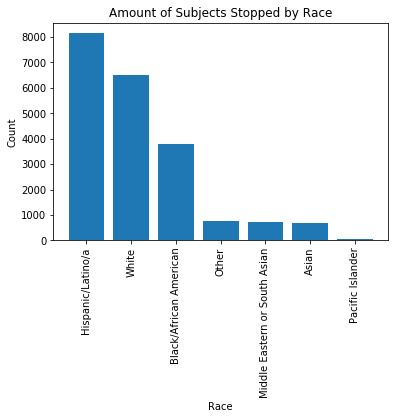

In [4]:
forgraphs = allyears.dropna()
r = forgraphs.subject_race.value_counts().to_frame()
plt.bar(r.index, r.subject_race)
plt.xlabel ('Race')
plt.ylabel ('Count')
plt.title ('Amount of Subjects Stopped by Race')
plt.xticks(rotation = 'vertical')
plt.show()

In [5]:
racethenservarea= pd.pivot_table(allyears, index= ['subject_race', 'service_area'], aggfunc={'stop_id': 'count',
...                              'subject_age': np.mean, 'property_seized': np.mean, 'searched':np.mean})
racethenservarea

property_seized  searched  stop_id  subject_age
subject_race service_area                                                 
Asian        110.0                0.411765  0.156627     1685    35.006579
             120.0                0.384615  0.243902     1267    34.431655
             130.0                     NaN  0.000000        3    44.666667
             230.0                0.033333  0.037286     1896    41.157309
             240.0                0.165217  0.054673     4549    38.959841
...                                    ...       ...      ...          ...
White        810.0                0.326034  0.155960    10767    39.007231
             820.0                0.286145  0.210513     6463    39.204224
             830.0                0.206897  0.247093     4703    39.385641
             840.0                     NaN  0.000000       13    36.700000
             930.0                0.216270  0.060215    19609    39.399240

[169 rows x 4 columns]

In [6]:
normal = pd.pivot_table(allyears, index= ['service_area', 'subject_race','subject_sex'], aggfunc={
...                              'property_seized': [np.mean, np.sum], 'searched':[np.mean, np.sum], 'subject_age':np.mean, 'stop_id': 'count'})



# Stops Rate

# Results

In [49]:
ret = get_VOD_df(allyears)
ret = ret[ret['year'] == 2014]
ret = ret.sort_values(by = 'time_stop')
ret['time_stop'] = [str(x.time()) for x in ret.time_stop]
ret['time_stop'] = [int(x[0:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:]) for x in ret.time_stop]
forgraph = pd.DataFrame(ret.groupby('time_stop')['stop_id'].count())

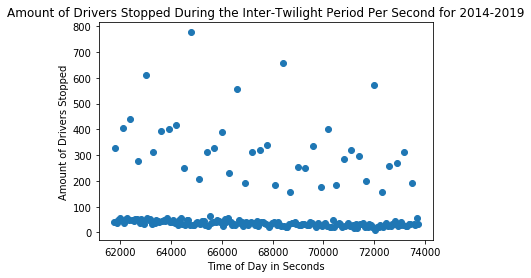

In [50]:
plt.scatter(x = forgraph.index, y= forgraph['stop_id'])
plt.xlabel ('Time of Day in Seconds')
plt.ylabel ('Amount of Drivers Stopped')
plt.title ('Amount of Drivers Stopped During the Inter-Twilight Period Per Second for 2014-2019')
#plt.xticks(rotation = 'vertical')
plt.show()

In [53]:
yk = allyears[allyears['year'] == 2014]
yk = yk.sort_values(by = 'time_stop').dropna()
yk['time_stop'] = [str(x.time()) for x in yk.time_stop]
yk['time_stop'] = [int(x[0:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:]) for x in yk.time_stop]
gt = pd.DataFrame(yk.groupby('time_stop')['stop_id'].count())

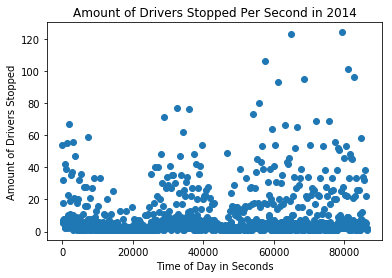

In [54]:
plt.scatter(x = gt.index, y= gt['stop_id'])
plt.xlabel ('Time of Day in Seconds')
plt.ylabel ('Amount of Drivers Stopped')
plt.title ('Amount of Drivers Stopped Per Second in 2014')
#plt.xticks(rotation = 'vertical')
plt.show()

In [55]:
fif = allyears[allyears['year'] == 2015]
fif = fif.sort_values(by = 'time_stop').dropna()
fif['time_stop'] = [str(x.time()) for x in fif.time_stop]
fif['time_stop'] = [int(x[0:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:]) for x in fif.time_stop]
yttt = pd.DataFrame(fif.groupby('time_stop')['stop_id'].count())

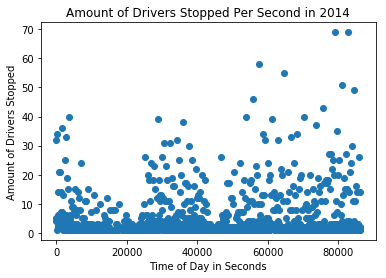

In [60]:
plt.scatter(x = yttt.index, y= yttt['stop_id'])
plt.xlabel ('Time of Day in Seconds')
plt.ylabel ('Amount of Drivers Stopped')
plt.title ('Amount of Drivers Stopped Per Second in 2014')
#plt.xticks(rotation = 'vertical')
plt.show()

In [18]:
poststop = pd.pivot_table(allyears, index= ['subject_race'], aggfunc={
...                              'arrested':np.mean, 'property_seized': np.mean, 'searched':np.mean, 'contraband_found':np.mean, 'subject_race': 'count'})
poststop.T

subject_race,Asian,Black/African American,Hispanic/Latino/a,Middle Eastern or South Asian,Native American,Other,Pacific Islander,White
arrested,0.007591,0.011818,0.010897,0.005123,0.0,0.005891,0.011689,0.007420
contraband_found,0.942837,0.912609,0.879845,0.885777,1.0,0.054450,0.969317,0.928430
property_seized,0.223958,0.262830,0.219527,0.092402,1.0,0.068783,0.515152,0.269058
searched,0.142512,0.282880,0.164409,0.049644,1.0,0.017156,0.402928,0.133591
subject_race,25955.000000,98276.000000,211160.000000,31120.000000,512.0,35395.000000,3029.000000,300396.000000


In [19]:
raceonly= pd.pivot_table(allyears, index= ['subject_race'], aggfunc={
...                              'arrested':np.mean, 'property_seized': np.mean, 'searched':np.mean, 'contraband_found':np.mean})
raceonly.T

subject_race,Asian,Black/African American,Hispanic/Latino/a,Middle Eastern or South Asian,Native American,Other,Pacific Islander,White
arrested,0.007591,0.011818,0.010897,0.005123,0.0,0.005891,0.011689,0.007420
contraband_found,0.942837,0.912609,0.879845,0.885777,1.0,0.054450,0.969317,0.928430
property_seized,0.223958,0.262830,0.219527,0.092402,1.0,0.068783,0.515152,0.269058
searched,0.142512,0.282880,0.164409,0.049644,1.0,0.017156,0.402928,0.133591


Text(0, 0.5, 'Mean Rates')

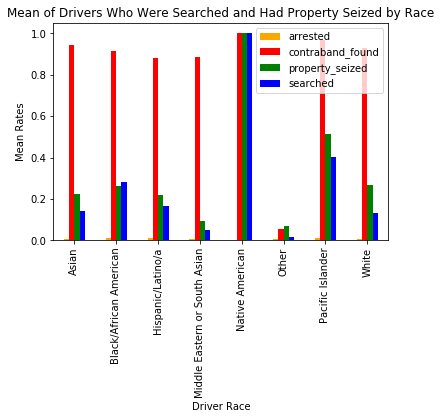

In [20]:
ax = raceonly.plot(kind = 'bar', title='Mean of Drivers Who Were Searched and Had Property Seized by Race',color=['orange', 'red', 'green', 'blue'])
ax.set_xlabel("Driver Race")
ax.set_ylabel("Mean Rates")
# plt.xlabel ('Race')
# plt.ylabel ('Percentage of Stops Having Property-Seized')
# plt.title ('Rates of Stops Resulting in Property Being Seized By Race')

In [2]:
rip = pd.pivot_table(allyears, index= ['year'], aggfunc={
...                              'arrested':np.mean, 'property_seized': np.mean, 'searched':np.mean, 'contraband_found':np.mean})

NameError: name 'pd' is not defined

In [1]:
rip.plot()

NameError: name 'rip' is not defined

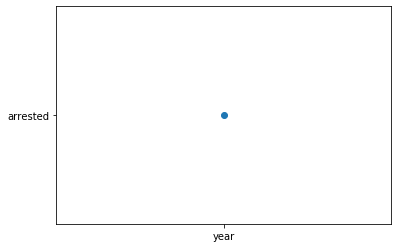

In [20]:
plt.scatter(x = 'year', y= 'arrested')

From the bar chart and table above, we can see that 27% of Native Americans are searched in comparison to the 20% of Whites and the 9.8% of Middle Easterns/South Asians. This is surprising because according to the SDSU study, these results are showing a majority of Native American searched as compared to the amount of African Americans searched. From the bar graph, we can see that there is a large amount of Native Americans searched. From the data, we can conclude that due to the small numbers of Native Americans searched, that about one fourth of them are searched.

# Precision, Accuracy and Missingness

#### Precision examples:

One example of where precision does not occur in the data is the post2018 dataset where the subject races are less granular than the pre2018 subject races. The pre2018 dataset splits the races into precise races like 'Laotian' and 'Vietnamese' where as the post2018 dataset combines those into the 'Asian' race.

Another example of precision is when the post2018 dataset was more precise in allocating gender to the stopped subjects whereas pre2018 only had 'M' for Males or 'F' for Females or 'X' for Unknown for those they had no idea about.

In [27]:
owd = os.getcwd()
os.chdir("data/raw")

In [28]:
fifteen = pd.concat([pd.read_csv(f) for f in newnames]).reset_index(drop = True).subject_race.value_counts()
pd.DataFrame(fifteen)

,subject_race
W,196665
H,141695
B,51754
O,35395
A,21695
F,6213
V,3348
C,2450
I,2280
X,713


In [29]:
pd.DataFrame(post2018.subject_race.value_counts())

,subject_race
White,103731
Hispanic/Latino/a,69465
Black/African American,46522
Asian,12189
Middle Eastern or South Asian,6796
Pacific Islander,2075
Native American,512


In [30]:
newtableee = pd.DataFrame()
subValCnts = pd.DataFrame(allyears.subject_race.value_counts())
newtableee['Driver Race'] = subValCnts.index
newtableee['Number Of Stops'] = list(pd.DataFrame(allyears.subject_race.value_counts())['subject_race'])
newtableee['Percentage of Stops'] = list(pd.DataFrame(allyears.subject_race.value_counts()/allyears.subject_race.value_counts().sum())['subject_race'])
newtableee

,Driver Race,Number Of Stops,Percentage of Stops
0,White,300396,0.425585
1,Hispanic/Latino/a,211160,0.299160
2,Black/African American,98276,0.139232
3,Other,35395,0.050146
4,Middle Eastern or South Asian,31120,0.044089
5,Asian,25955,0.036772
6,Pacific Islander,3029,0.004291
7,Native American,512,0.000725


In [31]:
fifteengend = pd.concat([pd.read_csv(f) for f in newnames ]).reset_index(drop = True).subject_sex.value_counts()
pd.DataFrame(fifteengend)

,subject_sex
M,301139
F,163924
X,66


In [32]:
pd.DataFrame(post2018.subject_sex.value_counts())

,subject_sex
1,178441
2,62151
3,385
4,240
0,73


#### Accuracy Examples:

Age is an example of data that is very hard to make accurate as there are legal ages for drivers but this data consists of not only ages that are too young to be legal and too old to be alive as well as strings. In order to graph the data, I decided to grab the rows with ages between 14 - 120. From the graph, we can see that the lines are thicker and longer near integers the end in 5's and 0's. This maybe because of officers perceiving age in the post2018 dataset (also has to do with precision when officers perceived age to be closer to 'bin ages').

Another example of accuracy is the race codes in the datasets. These are accurate because the officers had to bubble in the race codes so they were not misspelled or written with capitals or lower case letters. 

The stop causes for pre2018 are inaccurate as there are many of the same meanings with different inputs such as 'NOTHING MARKED', 'NOT SPECIFIED', and 'NOT MARKED'. This in return makes the data harder and more inefficient to clean because you'd have to loop through all of the unique inputs and map it to one form. 

In [33]:
pd.DataFrame(pre2018.stop_cause.value_counts()).head(15)

,stop_cause
Moving Violation,344856
Equipment Violation,114205
Radio Call/Citizen Contact,2181
"Muni, County, H&S Code",1625
Personal Knowledge/Informant,1011
No Cause Specified on a Card,707
"Suspect Info (I.S., Bulletin, Log)",644
Personal Observ/Knowledge,254
"UNI, &County, H&&S Code",73
"MUNI, County, H&S Code",55


Text(0.5, 1.0, 'Age of Drivers')

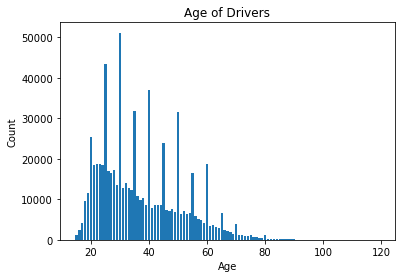

In [34]:
forgraphs = allyears
forgraphs = forgraphs[forgraphs['subject_age'] > 14]
forgraphs = forgraphs[forgraphs['subject_age'] < 120]
a = forgraphs.subject_age.value_counts().to_frame()
plt.bar(a.index, a.subject_age)
plt.xlabel ('Age')
plt.ylabel ('Count')
plt.title ('Age of Drivers')

#### Missingness: 

For a lot of the columns like property seized, searched, sd resident, I assumed that missing values meant that it did not pertaint to the subject stopped so in this case, I set the values to 0. Columns like age, I kept the missingness as float nans so that further along in the analysis, I could always go back and drop these rows or do some sort of imputation if I believed that these rows were integral to the analysis. 

I assumed from the data that one is only arrested, has property seized and has contraband found on them after they are searched.

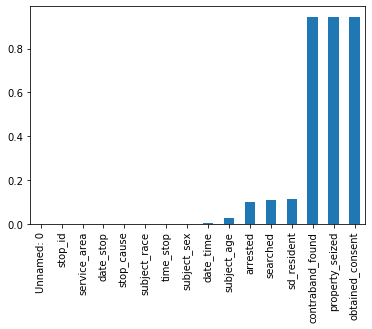

In [35]:
pd.concat([pd.read_csv(f) for f in newnames ]).reset_index(drop = True).isnull().mean().sort_values().plot(kind = 'bar')

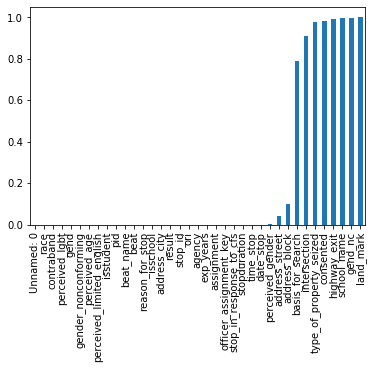

In [36]:
pt2018.isnull().mean().sort_values().plot(kind = 'bar')

# Veil of Darkness

For this section, we will do a replication of the inter-twilight analysis that was done in the SDSU study. The Veil of Darkness method aims to use data that is unbiased in terms of stop decisions. This method relies on the idea that the officers who were stopping individuals based on their races and skin colors would not affect the effect of post stop outcomes as it takes into consideration the amount of daylight and darkness outside. According to the study, "The naive approach is just to compare whether daytime stops or nighttime stops have higher proportion of black drivers". To adjust for the differences in the time of the sun setting throughout the year, we use the inter-twilight period which aims to focus on stops that occur within 5:09 PM and 8:29 PM. 

In [37]:
compute_intertwilight(allyears)

0.0671465270914718

In [38]:
vod_df = get_VOD_df(allyears)

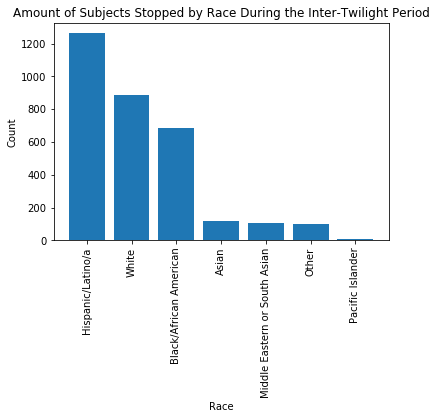

In [39]:
vodgraph = vod_df.dropna()
vcn = vodgraph.subject_race.value_counts().to_frame()
plt.bar(vcn.index, vcn.subject_race)
plt.xlabel ('Race')
plt.ylabel ('Count')
plt.title ('Amount of Subjects Stopped by Race During the Inter-Twilight Period')
plt.xticks(rotation = 'vertical')
plt.show()

In [40]:
pd.pivot_table(vod_df, index= ['subject_race', 'service_area','subject_sex'], aggfunc={
...                              'property_seized': np.mean, 'searched':np.mean, 'subject_age':np.mean})


property_seized  searched  subject_age
subject_race service_area subject_sex                                        
Asian        110.0        1.0                 0.000000  0.027027    39.108108
                          2.0                 0.000000  0.080000    32.259259
             120.0        1.0                 0.000000  0.157895    34.619048
                          2.0                      NaN  0.071429    31.928571
             230.0        1.0                 0.000000  0.000000    40.928571
...                                                ...       ...          ...
White        820.0        2.0                 0.000000  0.056604    39.286885
             830.0        1.0                 0.025000  0.170455    37.675258
                          2.0                 0.000000  0.088235    38.344828
             930.0        1.0                 0.086957  0.031637    39.542237
                          2.0                 0.200000  0.008850    40.131673

[266 rows x 3 columns]

In [41]:
pd.pivot_table(vod_df, index= ['service_area', 'subject_race','subject_sex'], aggfunc={
...                              'property_seized': np.mean, 'searched':np.mean, 'subject_age':np.mean})

property_seized  searched  \
service_area subject_race           subject_sex                              
110.0        Asian                  1.0                 0.000000  0.027027   
                                    2.0                 0.000000  0.080000   
             Black/African American 1.0                 0.333333  0.094595   
                                    2.0                 0.000000  0.054054   
             Hispanic/Latino/a      1.0                 0.208333  0.122363   
...                                                          ...       ...   
930.0        Other                  1.0                 0.000000  0.000000   
                                    2.0                 0.000000  0.014286   
             Pacific Islander       1.0                      NaN  0.000000   
             White                  1.0                 0.086957  0.031637   
                                    2.0                 0.200000  0.008850   

                                                 subject_age  
service_area subject_race           subject_sex               
110.0        Asian                  1.0            39.108108  
                                    2.0            32.259259  
             Black/African American 1.0            32.964286  
                                    2.0            36.837209  
             Hispanic/Latino/a      1.0            32.883895  
...                                                      ...  
930.0        Other                  1.0            36.941176  
                                    2.0            39.348315  
             Pacific Islander       1.0            41.333333  
             White                  1.0            39.542237  
                                    2.0            40.131673  

[266 rows x 3 columns]

In [3]:
aftervod = pd.pivot_table(vod_df, index= ['service_area', 'subject_race','subject_sex'], aggfunc={
...                              'property_seized': [np.mean, np.sum], 'searched':[np.mean, np.sum], 'subject_age':np.mean, 'stop_id': 'count'})


NameError: name 'pd' is not defined

# Comparison of All Data vs VOD

In [43]:
calculation = normal-aftervod

In [44]:
pd.DataFrame(calculation.mean())

0
property_seized mean      0.139702
                sum      26.827068
searched        mean      0.087534
                sum     249.127820
stop_id         count  2395.135338
subject_age     mean      0.799556

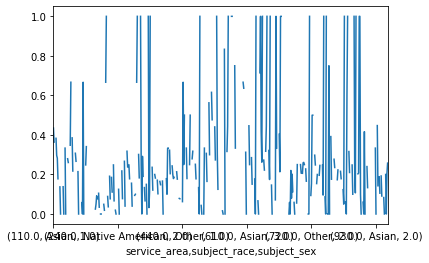

In [45]:
normal[('property_seized','mean')].plot()

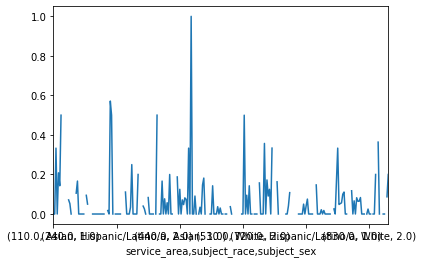

In [46]:
aftervod[('property_seized','mean')].plot()

In [47]:
idk = pd.pivot_table(vod_df, index= 'subject_race', aggfunc={
...                              'property_seized': [np.mean, np.sum], 'searched':[np.mean, np.sum], 'subject_age':np.mean, 'stop_id': 'count'})

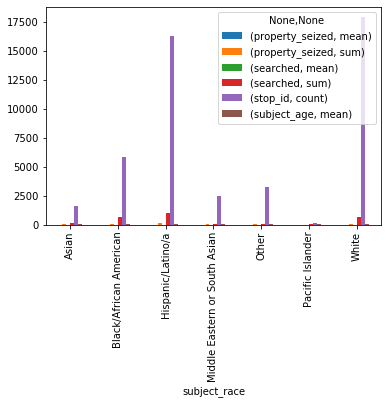

In [48]:
idk.plot(kind = 'bar')

In [49]:
idk2 = pd.pivot_table(allyears, index= 'subject_race', aggfunc={
...                              'property_seized': [np.mean, np.sum], 'searched':[np.mean, np.sum], 'subject_age':np.mean, 'stop_id': 'count'})

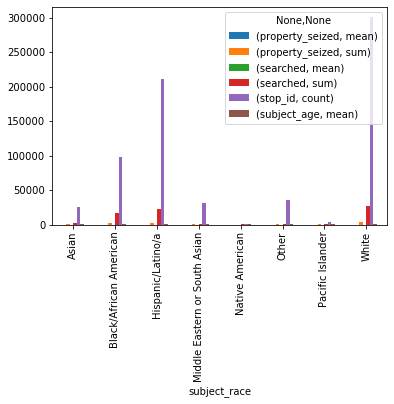

In [50]:
idk2.plot(kind = 'bar')

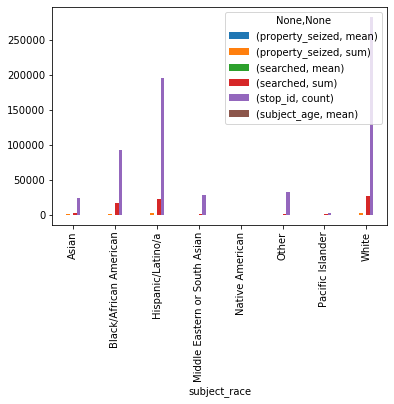

In [51]:
(idk2-idk).plot(kind = 'bar')

In [52]:
idk2-idk

property_seized          searched           \
                                         mean     sum      mean      sum   
subject_race                                                               
Asian                                0.107292   201.0  0.078550   1970.0   
Black/African American               0.199658  1556.0  0.155281  15925.0   
Hispanic/Latino/a                    0.145750  2460.0  0.091223  21712.0   
Middle Eastern or South Asian        0.051080    85.0  0.022126   1044.0   
Native American                           NaN     NaN       NaN      NaN   
Other                                0.014238    59.0 -0.000344    492.0   
Pacific Islander                     0.515152    68.0  0.275477    510.0   
White                                0.209522  2874.0  0.094371  26017.0   

                                stop_id subject_age  
                                  count        mean  
subject_race                                         
Asian                           24387.0   -0.324656  
Black/African American          92452.0    1.612815  
Hispanic/Latino/a              194873.0   -0.128380  
Middle Eastern or South Asian   28686.0    0.616617  
Native American                     NaN         NaN  
Other                           32181.0    0.777542  
Pacific Islander                 2910.0    1.007342  
White                          282479.0    1.179259

In [53]:
pd.pivot_table(allyears, index= ['subject_race', 'service_area'], aggfunc={
...                              'property_seized': [np.mean, np.sum], 'searched':[np.mean, np.sum], 'subject_age':np.mean, 'stop_id': 'count'})

property_seized         searched         stop_id  \
                                     mean    sum      mean     sum   count   
subject_race service_area                                                    
Asian        110.0               0.411765   14.0  0.156627   117.0    1685   
             120.0               0.384615   10.0  0.243902   130.0    1267   
             130.0                    NaN    0.0  0.000000     0.0       3   
             230.0               0.033333    2.0  0.037286    50.0    1896   
             240.0               0.165217   19.0  0.054673   172.0    4549   
...                                   ...    ...       ...     ...     ...   
White        810.0               0.326034  134.0  0.155960  1192.0   10767   
             820.0               0.286145   95.0  0.210513   805.0    6463   
             830.0               0.206897   90.0  0.247093   765.0    4703   
             840.0                    NaN    0.0  0.000000     0.0      13   
             930.0               0.216270  109.0  0.060215   789.0   19609   

                          subject_age  
                                 mean  
subject_race service_area              
Asian        110.0          35.006579  
             120.0          34.431655  
             130.0          44.666667  
             230.0          41.157309  
             240.0          38.959841  
...                               ...  
White        810.0          39.007231  
             820.0          39.204224  
             830.0          39.385641  
             840.0          36.700000  
             930.0          39.399240  

[169 rows x 6 columns]

In [54]:
aftervod.columns

MultiIndex([('property_seized',  'mean'),
            ('property_seized',   'sum'),
            (       'searched',  'mean'),
            (       'searched',   'sum'),
            (        'stop_id', 'count'),
            (    'subject_age',  'mean')],
           )

In [55]:
haha = aftervod.max(level=1)
haha


property_seized        searched        stop_id  \
                                         mean   sum      mean    sum   count   
subject_race                                                                   
Asian                                0.571429   4.0  0.350000   15.0     269   
Black/African American               0.357143   7.0  0.244845   98.0     604   
Hispanic/Latino/a                    1.000000  16.0  1.000000  116.0    3097   
Middle Eastern or South Asian        0.500000   1.0  0.147059   10.0     279   
Other                                1.000000   2.0  0.181818    6.0     369   
Pacific Islander                     0.000000   0.0  1.000000    3.0      11   
White                                0.200000  11.0  0.224490   66.0    1346   

                              subject_age  
                                     mean  
subject_race                               
Asian                            47.00000  
Black/African American           41.26506  
Hispanic/Latino/a                49.00000  
Middle Eastern or South Asian    60.00000  
Other                            41.00000  
Pacific Islander                 57.00000  
White                            48.00000

In [56]:
os.chdir(owd)

In [66]:
j = pd.read_csv('data/uploaded/joined.csv')
jdf = pd.DataFrame(j.groupby('serv')['H7X001'].sum())
jdf

,H7X001
serv,
0,0
110,127318
120,89063
230,109952
240,108664
310,66967
320,74494
430,114663
440,50764


In [67]:
totdf = pd.DataFrame(allyears.groupby('service_area')['subject_race'].count())
totdf

,subject_race
service_area,
110.0,42407
120.0,63901
130.0,253
230.0,28068
240.0,37281
310.0,55223
320.0,27935
430.0,28251
440.0,26681


In [68]:
combo = jdf.join(totdf, how = 'outer')
combo['percentage'] = combo['subject_race']/combo['H7X001']
combo = combo.columns(columns={"H7X001": "Population", "subject_race": "Number of Stops", "percentage": "% of Stops/Population"})

,H7X001,subject_race,percentage
0.0,0.0,NaN,NaN
110.0,127318.0,42407.0,0.333079
120.0,89063.0,63901.0,0.717481
130.0,NaN,253.0,NaN
230.0,109952.0,28068.0,0.255275
240.0,108664.0,37281.0,0.343085
310.0,66967.0,55223.0,0.824630
320.0,74494.0,27935.0,0.374997
430.0,114663.0,28251.0,0.246383
440.0,50764.0,26681.0,0.525589


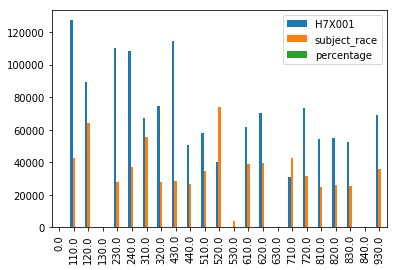

In [69]:
combo.plot(kind = 'bar')

In [84]:
beat_url = 'http://seshat.datasd.org/sde/pd/pd_beats_datasd.geojson'
pol = gpd.read_file(beat_url)
cp = pol.copy()

In [85]:
cp =cp.join(combo, on = 'serv')

In [86]:
cp

,objectid,beat,div,serv,name,geometry,H7X001,subject_race,percentage
0,3,935,9,930,NORTH CITY,"MULTIPOLYGON (((-117.20425 32.96202, -117.2043...",69028.0,36046.0,0.522194
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((-117.22525 32.70269, -117.2252...",0.0,NaN,NaN
2,9,511,5,510,,"MULTIPOLYGON (((-117.22525 32.70269, -117.2249...",58180.0,34706.0,0.596528
3,10,722,7,720,NESTOR,"POLYGON ((-117.08714 32.58382, -117.08695 32.5...",73187.0,31341.0,0.428232
4,11,314,3,310,BIRDLAND,"POLYGON ((-117.15377 32.78024, -117.15425 32.7...",66967.0,55223.0,0.824630
...,...,...,...,...,...,...,...,...,...
135,614,243,2,240,MIRAMAR,"POLYGON ((-117.11626 32.90024, -117.11620 32.8...",108664.0,37281.0,0.343085
136,620,937,9,930,BLACK MOUNTAIN RANCH,"POLYGON ((-117.09962 32.99798, -117.09962 32.9...",69028.0,36046.0,0.522194
137,621,936,9,930,TORREY HIGHLANDS,"POLYGON ((-117.14402 32.97754, -117.14413 32.9...",69028.0,36046.0,0.522194
138,622,233,2,230,RANCHO PENASQUITOS,"POLYGON ((-117.08329 32.99663, -117.08335 32.9...",109952.0,28068.0,0.255275


/Users/hudaahmed/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


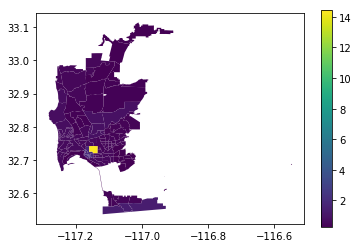

In [96]:
cp.plot(column='percentage', legend = True)

In [91]:
cp2 = cp[cp['serv'] != 530]

/Users/hudaahmed/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


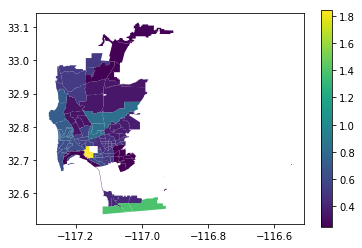

In [95]:
gp = cp2.plot(column='percentage', legend= True)